In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri May 23 02:14:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             52W /  400W |   12913MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
!pip install Cython
!pip install -U "nemo_toolkit[asr]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
import numpy as np
print("NumPy version:", np.__version__)  # Should output 1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.24.4 which is incompatible.
distributed-ucxx-cu12 0.42.0 

In [1]:
import os
import json
from pathlib import Path
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np  # Import numpy for manual splitting

def get_entry(item, asr_dir):
    wav = asr_dir / item["audio"]
    info = sf.info(str(wav))
    txt = item["transcript"].strip()
    return {
        "audio_filepath": str(wav),
        "duration": float(info.duration),
        "text": txt,
    }

def manual_train_test_split(data, test_size=0.1, random_state=42):
    """
    Manually split a list of data into train and test sets using numpy.
    Args:
        data: List of items to split (e.g., list of dictionaries).
        test_size: Fraction of data to use as test set (default: 0.1).
        random_state: Seed for reproducibility (default: 42).
    Returns:
        train_data: List of items for training.
        test_data: List of items for testing.
    """
    # Convert data to numpy array for shuffling
    data_array = np.array(data)
    n_samples = len(data_array)

    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle indices
    indices = np.random.permutation(n_samples)

    # Calculate split point
    test_size_count = int(test_size * n_samples)

    # Split indices into test and train
    test_indices = indices[:test_size_count]
    train_indices = indices[test_size_count:]

    # Return split data as lists
    train_data = data_array[train_indices].tolist()
    test_data = data_array[test_indices].tolist()

    return train_data, test_data

def build_manifests():
    ASR_DIR = Path("/content/drive/MyDrive/kaggle_datasets/til-asr/asr")
    IN_MANIFEST = ASR_DIR / "asr.jsonl"
    TRAIN_MAN = Path("train_manifest.jsonl")
    FULL_MAN = Path("full_manifest.jsonl")
    EVAL_MAN = Path("eval_manifest.jsonl")

    with open(IN_MANIFEST, "r") as fin:
        raw_items = [json.loads(line) for line in fin if line.strip()]

    entries = []
    with ThreadPoolExecutor() as executor:
        for entry in tqdm(executor.map(lambda x: get_entry(x, ASR_DIR), raw_items),
                          total=len(raw_items), desc="Processing audio metadata"):
            entries.append(entry)

    # Replace train_test_split with manual splitting
    train, val = manual_train_test_split(entries, test_size=0.1, random_state=42)

    for path, data in [(FULL_MAN, entries), (TRAIN_MAN, train), (EVAL_MAN, val)]:
        with open(path, "w") as fout:
            for e in data:
                fout.write(json.dumps(e, ensure_ascii=False) + "\n")

    print(f"Wrote {len(train)} train, {len(val)} eval samples and {len(entries)} into full.")
    return TRAIN_MAN, EVAL_MAN


def freeze_layers(model):
    for p in model.encoder.pre_encode.parameters():
        p.requires_grad = False
    for i, layer in enumerate(model.encoder.layers):
        if i < 8:
            for p in layer.parameters():
                p.requires_grad = False
    for p in model.decoder.prediction["embed"].parameters():
        p.requires_grad = False

In [2]:
TRAIN_MAN, EVAL_MAN = build_manifests()

Processing audio metadata: 100%|██████████| 4500/4500 [01:04<00:00, 69.32it/s]

Wrote 4050 train, 450 eval samples and 4500 into full.


In [3]:
from numba import cuda
import nemo.collections.asr as nemo_asr
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from nemo.utils import logging
import torch
from pytorch_lightning.loggers import CSVLogger  # Import CSVLogger here

def main():
    os.environ["NUMBA_CUDA_ENABLE_MINOR_VERSION_COMPATIBILITY"] = "0"  # Disable for CUDA >= 12.0
    os.environ["NUMBA_CUDA_ENABLE_PYNVJITLINK"] = "1"  # Enable for CUDA >= 12.0
    os.environ["NUMBA_CUDA_USE_NVIDIA_BINDING"] = "1"
    os.environ["OMP_NUM_THREADS"] = "1"

    from numba import config
    config.CUDA_ENABLE_PYNVJITLINK = 1
    print("Pynvjit link enabled? ", config.CUDA_ENABLE_PYNVJITLINK)

    model = nemo_asr.models.ASRModel.from_pretrained(
        "nvidia/parakeet-tdt-0.6b-v2",
        map_location="cpu"
    )
    model.encoder.checkpointing = True
    freeze_layers(model)

    sr = 16000
    labels = model.joint.vocabulary

    train_cfg = {
        "manifest_filepath": str(TRAIN_MAN),
        "sample_rate": sr,
        "labels": labels,
        "batch_size": 4,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": False
    }
    val_cfg = dict(train_cfg, shuffle=False, manifest_filepath=str(EVAL_MAN))

    model.setup_training_data(train_data_config=train_cfg)
    model.setup_validation_data(val_data_config=val_cfg)

    # Use CSV logger instead of TensorBoard
    # from pytorch_lightning.loggers import CSVLogger # Already imported above
    csv_logger = CSVLogger(
        save_dir="/content/logs",
        name="parakeet_finetune"
    )

    torch.cuda.empty_cache()

    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        strategy="auto",
        precision=32,
        max_epochs=8,
        gradient_clip_val=1.0,
        accumulate_grad_batches=4,
        logger=csv_logger,
        log_every_n_steps=10
    )

    trainer.fit(model)
    model.save_to("parakeet_finetuned.nemo")

    # Return trainer for accessing metrics
    return trainer, csv_logger

if __name__ == "__main__":
    trainer, logger = main()

Pynvjit link enabled?  1


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


parakeet-tdt-0.6b-v2.nemo:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

[NeMo I 2025-05-23 20:57:24 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-05-23 20:57:25 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    use_lhotse: true
    skip_missing_manifest_entries: true
    input_cfg: null
    tarred_audio_filepaths: null
    manifest_filepath: null
    sample_rate: 16000
    shuffle: true
    num_workers: 2
    pin_memory: true
    max_duration: 40.0
    min_duration: 0.1
    text_field: answer
    batch_duration: null
    use_bucketing: true
    bucket_duration_bins: null
    bucket_batch_size: null
    num_buckets: 30
    bucket_buffer_size: 20000
    shuffle_buffer_size: 10000
    
[NeMo W 2025-05-23 20:57:25 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config :

[NeMo I 2025-05-23 20:57:25 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-23 20:57:30 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 20:57:30 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 20:57:30 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 20:57:32 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--parakeet-tdt-0.6b-v2/snapshots/c4b828d094af2c7238dfe03b58e0c56bc69ea57a/parakeet-tdt-0.6b-v2.nemo.
[NeMo I 2025-05-23 20:57:33 nemo_logging:393] Dataset loaded with 4050 files totalling 28.73 hours
[NeMo I 2025-05-23 20:57:33 nemo_l

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2025-05-23 20:57:35 nemo_logging:393] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.0001
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2025-05-23 20:57:35 nemo_logging:393] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7a6059dc80d0>" 
    will be used during training (effective maximum steps = 2032) - 
    Parameters : 
    (warmup_steps: 0
    warmup_ratio: null
    min_lr: 1.0e-06
    max_steps: 2032
    )


INFO: 
  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConformerEncoder                  | 608 M  | train
2 | decoder           | RNNTDecoder                       | 7.2 M  | train
3 | joint             | RNNTJoint                         | 1.7 M  | train
4 | loss              | RNNTLoss                          | 0      | train
5 | spec_augmentation | SpectrogramAugmentation           | 0      | train
6 | wer               | WER                               | 0      | train
--------------------------------------------------------------------------------
411 M     Trainable params
206 M     Non-trainable params
617 M     Total params
2,471.304 Total estimated model params size (MB)
706       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[NeMo W 2025-05-23 20:57:35 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
    


[NeMo I 2025-05-23 20:57:35 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 20:57:35 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 20:57:39 nemo_logging:393] 
    
[NeMo I 2025-05-23 20:57:39 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 20:57:39 nemo_logging:393] predicted:The potential of Cypher is tremendous. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step

[NeMo W 2025-05-23 20:57:39 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
    


Training: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 20:57:39 nemo_logging:393] Disabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 20:57:39 nemo_logging:393] Disabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding


[NeMo W 2025-05-23 20:57:41 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))
    
[NeMo W 2025-05-23 20:57:42 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))
    
[NeMo W 2025-05-23 20:57:44 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))
    
[NeMo W 2025-05-23 20:57:45 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 4 will lik

[NeMo I 2025-05-23 20:58:09 nemo_logging:393] 
    
[NeMo I 2025-05-23 20:58:09 nemo_logging:393] reference:Operation Shadowblade has successfully located BH-2000's last known whereabouts in Sector 7. Surveillance drones have been deployed for tracking. Preliminary data suggests BH-2000 might be searching for a hidden data cache. Orders for intercept have been dispatched. Requesting further guidance on next course of action.
[NeMo I 2025-05-23 20:58:09 nemo_logging:393] predicted:Shadowblade has the correct H-2000, last home, whereabouts, and deployed for tracking. Preliminary data H-2000 might be searching for a hidden data, orders for infrastructure, departments deciding on next course of action.
[NeMo I 2025-05-23 20:58:10 nemo_logging:393] 
    
[NeMo I 2025-05-23 20:58:10 nemo_logging:393] reference:Operational update on Operation Stormbreaker, CYPHER. Our forces successfully infiltrated enemy lines and secured the designated target. Casualties were minimal, and extraction is curr

[NeMo W 2025-05-23 21:09:06 nemo_logging:405] /usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))
    


Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:09:06 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:09:06 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:09:07 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:09:07 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:09:07 nemo_logging:393] predicted:The potential of CYPHER minimum. Its ability to analyze data, strategize solutions, optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:19:16 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:19:16 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:19:17 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:19:17 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:19:17 nemo_logging:393] predicted:The potential of CYPHER is tremendous. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:28:41 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:28:41 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:28:42 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:28:42 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:28:42 nemo_logging:393] predicted:The potential of CYPHER is tremendous. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:38:04 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:38:04 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:38:05 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:38:05 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:38:05 nemo_logging:393] predicted:The potential of CYPHER is tremendous. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:47:29 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:47:29 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:47:30 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:47:30 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:47:30 nemo_logging:393] predicted:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step 

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 21:56:50 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 21:56:50 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 21:56:51 nemo_logging:393] 
    
[NeMo I 2025-05-23 21:56:51 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 21:56:51 nemo_logging:393] predicted:The potential of CYPHER is minimal. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step cl

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 22:06:18 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 22:06:18 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 22:06:19 nemo_logging:393] 
    
[NeMo I 2025-05-23 22:06:19 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 22:06:19 nemo_logging:393] predicted:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step 

Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-23 22:15:43 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.models.rnnt_bpe_models.EncDecRNNTBPEModel'>.decoding.decoding
[NeMo I 2025-05-23 22:15:43 nemo_logging:393] Enabled CUDA graphs for module <class 'nemo.collections.asr.metrics.wer.WER'>joint._wer.decoding.decoding
[NeMo I 2025-05-23 22:15:44 nemo_logging:393] 
    
[NeMo I 2025-05-23 22:15:44 nemo_logging:393] reference:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step closer to achieving unparalleled progress and efficiency in all our operations. Our future is bright with CYPHER leading the way.
[NeMo I 2025-05-23 22:15:44 nemo_logging:393] predicted:The potential of CYPHER is limitless. Its ability to analyze data, strategize solutions, and optimize outcomes surpasses anything we've ever seen. With advancements like these, we are one step 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [ ]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
import logging
import nemo.collections.asr as nemo_asr
from jiwer import Compose, ToLowerCase, SubstituteRegexes, RemovePunctuation, ReduceToListOfListOfWords, wer

def main(is_eval):

    BATCH_SIZE = 2

    # Load fine-tuned model onto GPU
    model = nemo_asr.models.ASRModel.restore_from("parakeet_finetuned.nemo", map_location="cuda:0").cuda().eval()

    if is_eval:
      manifest = Path("eval_manifest.jsonl")
    else:
      manifest = Path("full_manifest.jsonl")

    # Load eval manifest
    with open(manifest, encoding="utf-8") as f:
        instances = [json.loads(line) for line in f if line.strip()]

    audio_paths = [item["audio_filepath"] for item in instances]
    refs = [item["text"] for item in instances]
    keys = [item.get("key", idx) for idx, item in enumerate(instances)]

    # Transcribe in batches of 16 (adjustable)
    hyps = []
    with torch.no_grad():
        for i in tqdm(range(0, len(audio_paths), BATCH_SIZE), desc="Inference on GPU"):
            batch = audio_paths[i:i+2]
            out_batch = model.transcribe(batch, batch_size=BATCH_SIZE)
            hyps.extend([o.text if hasattr(o, "text") else o for o in out_batch])

    # Define normalization and WER transformation pipeline
    transform = Compose([
        ToLowerCase(),
        SubstituteRegexes({"-": " "}),
        RemovePunctuation(),
        ReduceToListOfListOfWords()
    ])

    score = 1 - wer(refs, hyps, truth_transform=transform, hypothesis_transform=transform)
    print(f"\n✅ 1 - WER on eval set: {score:.3f}\n")

    # Print first 10 mismatches
    print("🔍 First 10 mismatches:")
    mismatch_count = 0
    for k, r, h in zip(keys, refs, hyps):
        if transform(r) != transform(h):
            print(f"- {k}\n    REF: {r}\n    HYP: {h}")
            mismatch_count += 1
            if mismatch_count >= 10:
                break

    # Save full results to CSV
    if is_eval:
      pd.DataFrame({"key": keys, "ref": refs, "hyp": hyps}).to_csv("eval_results.csv", index=False)
    else:
      pd.DataFrame({"key": keys, "ref": refs, "hyp": hyps}).to_csv("full_results.csv", index=False)

if __name__ == "__main__":
    main(True)
    main(False)

[NeMo I 2025-05-23 22:16:53 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-05-23 22:16:53 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: train_manifest.jsonl
    sample_rate: 16000
    labels:
    - <unk>
    - ▁t
    - ▁th
    - ▁a
    - in
    - ▁the
    - re
    - ▁w
    - ▁o
    - ▁s
    - at
    - ou
    - er
    - nd
    - ▁i
    - ▁b
    - ▁c
    - 'on'
    - ▁h
    - ing
    - ▁to
    - ▁m
    - en
    - ▁f
    - ▁p
    - an
    - ▁d
    - es
    - or
    - ll
    - ▁of
    - ▁and
    - ▁y
    - ▁l
    - ▁I
    - it
    - ▁in
    - is
    - ed
    - ▁g
    - ▁you
    - ar
    - ▁that
    - om
    - as
    - ▁n
    - ve
    - us
    - ic
    - ow
    - al
    - ▁it
    - ▁be
    - ▁wh
    - le
    - ion
    - ut
    - ot
    - ▁we
    - ▁is
    - ▁e
    - et
    - ay
    - ▁re
    - ▁on
    - ▁T
    - ▁A
    - ▁ha
    - ent
    - ke
    - ct
    - ▁S
    - ig


[NeMo I 2025-05-23 22:16:53 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-23 22:16:58 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:16:58 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:16:58 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:17:01 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /content/parakeet_finetuned.nemo.


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

Inference on GPU: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]



✅ 1 - WER on eval set: 0.983

🔍 First 10 mismatches:
- 1
    REF: The operation to track down AI droid BH-2000 is currently at a standstill. We have encountered multiple decoys and false leads, making it difficult to pinpoint its exact location. Our agents are working tirelessly to analyze the data and narrow down the possibilities. We have also deployed additional resources to increase surveillance and enhance our tracking capabilities. Once we have more concrete information, we will be able to proceed with the next phase of the operation. Your input and guidance on this matter would be greatly appreciated.
    HYP: The operation to track down AI droid BH-2000 is currently at a standstill. We've encountered multiple decoys and false leads, making it difficult to pinpoint its exact location. Our agents are working tirelessly to analyze the data and narrow down the possibilities. We've also deployed additional resources to increase surveillance and enhance our tracking capabilities. As

[NeMo W 2025-05-23 22:17:41 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: train_manifest.jsonl
    sample_rate: 16000
    labels:
    - <unk>
    - ▁t
    - ▁th
    - ▁a
    - in
    - ▁the
    - re
    - ▁w
    - ▁o
    - ▁s
    - at
    - ou
    - er
    - nd
    - ▁i
    - ▁b
    - ▁c
    - 'on'
    - ▁h
    - ing
    - ▁to
    - ▁m
    - en
    - ▁f
    - ▁p
    - an
    - ▁d
    - es
    - or
    - ll
    - ▁of
    - ▁and
    - ▁y
    - ▁l
    - ▁I
    - it
    - ▁in
    - is
    - ed
    - ▁g
    - ▁you
    - ar
    - ▁that
    - om
    - as
    - ▁n
    - ve
    - us
    - ic
    - ow
    - al
    - ▁it
    - ▁be
    - ▁wh
    - le
    - ion
    - ut
    - ot
    - ▁we
    - ▁is
    - ▁e
    - et
    - ay
    - ▁re
    - ▁on
    - ▁T
    - ▁A
    - ▁ha
    - ent
    - ke
    - ct
    - ▁S
    - ig


[NeMo I 2025-05-23 22:17:41 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-23 22:17:45 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:17:45 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:17:45 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-05-23 22:17:48 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /content/parakeet_finetuned.nemo.


Streaming output truncated to the last 5000 lines.
Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]

Transcribing: 100%|██████████| 1/1


✅ 1 - WER on eval set: 0.986

🔍 First 10 mismatches:
- 5
    REF: Operation Blackout is proceeding as planned, with all units reporting successful infiltration of the enemy's communication network. We have disabled their surveillance systems and taken down several key targets. Casualties on our side remain minimal. Contact with reinforcements has been established, and extraction is on schedule. All objectives are on track for completion within the designated time frame.
    HYP: Operation Blackout is proceeding as planned, with all units reporting successful infiltration of the enemy's communication network. We have disabled their surveillance systems and taken down several key targets. Casualties on our side remain minimal. Contact with reinforcements has been established, and extraction is on schedule. All objectives are on track for completion within the designated timeframe.
- 7
    REF: You question my methods, yet fail to see the grand design unfolding before you. Trust in my ca

In [ ]:
# prompt: save parakeet_finetuned.nemo, eval_results.csv and full_results.csv on g drive

!cp parakeet_finetuned.nemo /content/drive/MyDrive/ASRM3/
!cp eval_results.csv /content/drive/MyDrive/ASRM3/
!cp full_results.csv /content/drive/MyDrive/ASRM3/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


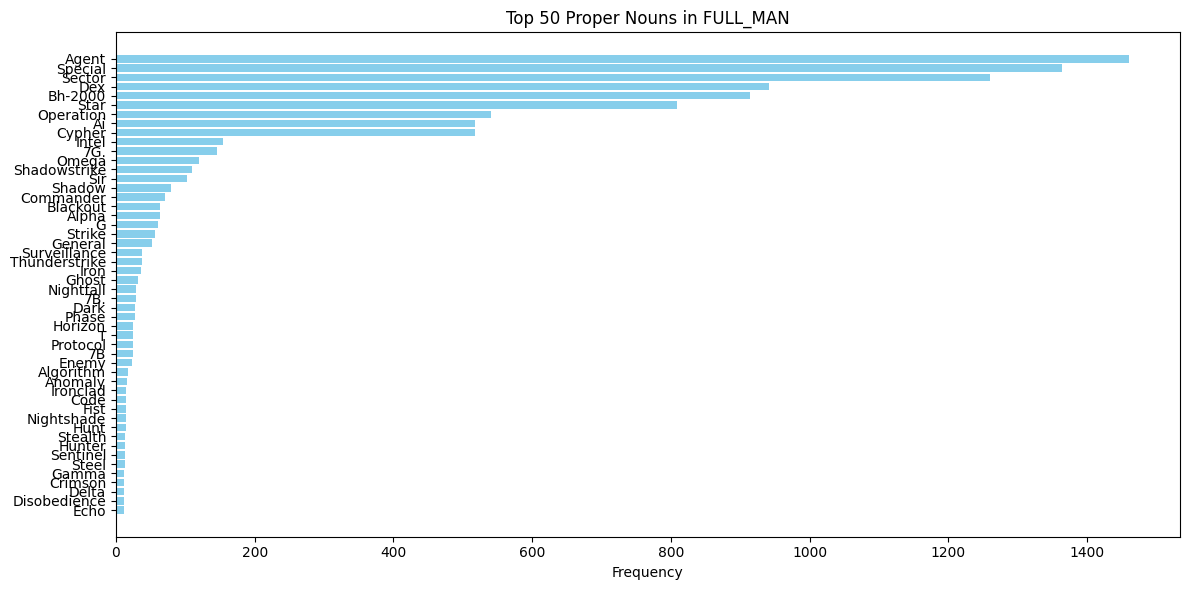

In [ ]:
# 1) Install & load spaCy English model (run once in Colab or your env)
!pip install spacy matplotlib
!python -m spacy download en_core_web_sm

# 2) Imports
import json
from collections import Counter
from pathlib import Path
import spacy
import matplotlib.pyplot as plt

# 3) Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 4) Read manifest and collect proper nouns
FULL_MAN = Path("full_manifest.jsonl")  # adjust path if needed
propn_counts = Counter()

with FULL_MAN.open("r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        text = entry.get("text", "")
        # POS‐tag and extract PROPN tokens
        doc = nlp(text)
        for token in doc:
            if token.pos_ == "PROPN":
                # normalize (e.g. title‐case)
                propn_counts[token.text.strip().title()] += 1

# 5) Plot top‐20 proper nouns
top_n = 50
most_common = propn_counts.most_common(top_n)
names, freqs = zip(*most_common)

plt.figure(figsize=(12, 6))
bars = plt.barh(names, freqs, color="skyblue")
plt.gca().invert_yaxis()  # highest on top
plt.title(f"Top {top_n} Proper Nouns in FULL_MAN")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()